In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler


In [2]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [3]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df = combine_csvs_from_folder('market_data/merged_data')

df.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,WMA,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,company
54039,0.836382,0.618820,0.098034,0.135600,0.750070,0.20,0.85,0.825,0.349887,0.916590,...,0.919478,0.775004,0.777489,0.784578,0.780133,0.910496,0.049474,0.0,0.0,10
54040,0.838415,0.621788,0.096431,0.133143,0.760952,0.15,0.80,0.825,0.345309,0.918329,...,0.922155,0.781107,0.788813,0.792659,0.788697,0.918977,0.044222,0.0,0.0,10
54041,0.835553,0.613781,0.102918,0.140160,0.779426,0.10,1.00,0.950,0.347403,0.920624,...,0.924281,0.793524,0.799283,0.797516,0.785984,0.916290,0.042542,0.0,0.0,10
54042,0.841508,0.619601,0.112941,0.157132,0.798503,0.05,1.00,0.975,0.353149,0.925806,...,0.928223,0.791532,0.804615,0.803834,0.806673,0.936779,0.081344,0.0,0.0,10
54043,0.843942,0.623524,0.128798,0.174423,0.822713,0.00,1.00,1.000,0.347510,0.931589,...,0.932376,0.806493,0.813785,0.818619,0.812312,0.942363,0.107260,0.0,0.0,10


In [4]:
#we need this for later
def find_indices_of_last_company_changes(df):
    indices = []
    for i in range(1, len(df)):
        if df.loc[i, 'company'] != df.loc[i - 1, 'company']:
            indices.append(i-10)
    return indices
idxs = find_indices_of_last_company_changes(df)
idxs.append(len(df) - 11)



In [5]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df['company'] = df['company'].astype(str)
df = pd.get_dummies(df, columns=['company'])

In [6]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = 0
    
    # Loop over the rows (skipping the first row)
    for i in range(1, len(df)):
        if df.loc[i, '4. close'] > df.loc[i-1, '4. close']:
            df.loc[i, 'up'] = 1
    return df


df = add_up_column(df)
df.head()


,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,company_10,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,up
0,0.172135,0.545425,0.154470,0.101243,0.502764,0.95,0.25,0.15,0.010778,0.004883,...,0,0,0,0,0,0,0,0,0,0
1,0.169640,0.532056,0.164471,0.106557,0.502062,0.90,0.20,0.15,0.010778,0.004920,...,0,0,0,0,0,0,0,0,0,0
2,0.173826,0.555077,0.164130,0.114041,0.502022,0.85,0.15,0.15,0.011184,0.004920,...,0,0,0,0,0,0,0,0,0,1
3,0.177859,0.590061,0.159311,0.123042,0.501608,0.80,0.10,0.15,0.011078,0.004897,...,0,0,0,0,0,0,0,0,0,1
4,0.173893,0.583195,0.149749,0.131813,0.501044,0.75,0.05,0.15,0.011167,0.004806,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df)
print(inputs.shape)
print(targets.shape)

torch.Size([54044, 84])
torch.Size([54044, 1])


In [8]:
def create_sequences(inputs, targets, seq_length):
    seq_inputs = []
    seq_targets = []
    for i in range(len(inputs) - seq_length):
        seq_inputs.append(inputs[i:i + seq_length])
        seq_targets.append(targets[i + seq_length])
    return torch.stack(seq_inputs), torch.stack(seq_targets)

sequence_length = 10
seq_inputs, seq_targets  = create_sequences(inputs, targets, sequence_length)

print(seq_inputs.shape)
print(seq_targets.shape)

torch.Size([54034, 10, 84])
torch.Size([54034, 1])


In [9]:
# making a training and validation dataset

dataset = TensorDataset(seq_inputs, seq_targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# pytorch uses dataloaders to load data in batches

batch_size = 256
train_loader = DataLoader(dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, 12, shuffle = False, num_workers = 0)

In [11]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class LSTM_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# input size is 84 because we have 84 columns in our dataframe
# output size is 1 because we are predicting up=1 or down=0
input_size = 84
output_size = 1
hidden_size = 256
num_layers = 5
model = LSTM_NN(input_size, hidden_size, num_layers, output_size)
model.to(device)

LSTM_NN(
  (lstm): LSTM(84, 256, num_layers=5, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100

In [14]:
# training loop
training_losses = []
sequence_length = 10
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.view(-1, sequence_length, input_size)
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 10 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.6929156479408156
epoch: 10, avg_loss: 0.6916060487054428
epoch: 20, avg_loss: 0.6892339727788601
epoch: 30, avg_loss: 0.685061828145441
epoch: 40, avg_loss: 0.6746536875670811
epoch: 50, avg_loss: 0.6387628814521825
epoch: 60, avg_loss: 0.5712546756807363
epoch: 70, avg_loss: 0.47748914276653864
epoch: 80, avg_loss: 0.38781692537496676
epoch: 90, avg_loss: 0.306452603272672
epoch: 100, avg_loss: 0.23391669398208834


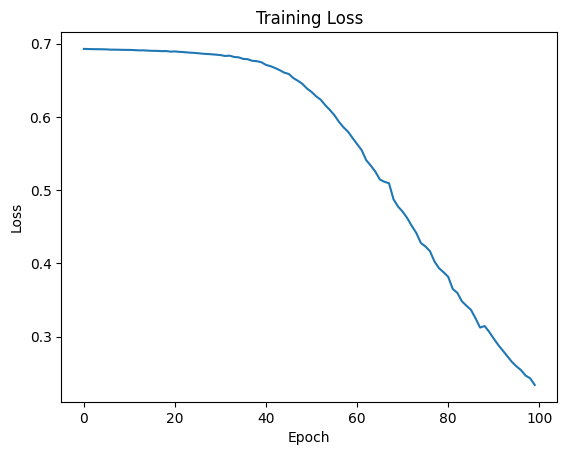

In [15]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    flag = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs = inputs.view(-1, sequence_length, input_size)
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            if flag == 0:
                print(targets.view(-1))
                print(torch.round(outputs.view(-1)))
                flag = 1
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0')
val_loss: 0.13774297452204537, val_acc: 0.9433700379383733


In [17]:
# how will visa do tomorrow? > 0.5 = up, < 0.5 = down
model(seq_inputs[len(seq_inputs)-1].unsqueeze(0).to(device))

tensor([[0.5237]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir("market_data/merged_data/") if f.endswith('.csv')]

for i, idx in enumerate(idxs):
    print(f"{filenames[i]}: {model(seq_inputs[idx].unsqueeze(0).to(device)).item():.2f}")


AAPL: 0.01
AMZN: 1.00
GOOG: 0.99
GOOGL: 1.00
MSFT: 0.01
NVDA: 0.04
PCAR: 0.00
TSLA: 0.99
TSM: 0.02
UNH: 0.49
V: 0.52
